In [1]:
%pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import datasets
from PIL import Image
from tqdm import tqdm

In [3]:
class config:
    image_size = (256, 256)
    components = 100

In [14]:
# Function to load RGB images from a folder, resize, flatten, and assign labels
def load_rgb_images(folder, label, size=config.image_size):
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading RGB from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB').resize(size)
            images.append(np.array(img).flatten())  # flatten to convert image into a vector
            labels.append(label)
    return images, labels


# Function to load NDVI images from a folder, resize, and flatten (NO RGB conversion)
def load_ndvi_images(folder, size=config.image_size):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder), desc=f"Loading NDVI from {folder}"):
        if filename.endswith('.jpg') or filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize(size)  # NO .convert('RGB') - keep as grayscale
            images.append(np.array(img).flatten())  # flatten to convert image into a vector
            filenames.append(filename)
    return images, filenames


In [15]:
# Define paths
label_path = r"C:\Users\Angel\Downloads\Learning_Path\Task_1\labels"   # NDVI images
sample_path = r"C:\Users\Angel\Downloads\Learning_Path\Task_1\samples"  # RGB images

# Load RGB samples (these will be your training features X)
rgb_images, _ = load_rgb_images(sample_path, label=0)
samples_array = np.array(rgb_images)

# Load NDVI labels (these will be used to generate ground truth labels y)
ndvi_images, ndvi_filenames = load_ndvi_images(label_path)
labels_array = np.array(ndvi_images)


Loading RGB from C:\Users\Angel\Downloads\Learning_Path\Task_1\samples: 100%|██████████| 614/614 [00:00<00:00, 1498.62it/s]
Loading NDVI from C:\Users\Angel\Downloads\Learning_Path\Task_1\labels: 100%|██████████| 614/614 [00:00<00:00, 1416.07it/s]


In [17]:
mean_ndvi = np.nanmean(labels_array, axis=1)
threshold = np.median(mean_ndvi)

# Create binary labels based on NDVI:
# 0 = Unhealthy (NDVI <= threshold, darker pixels)
# 1 = Healthy (NDVI > threshold, lighter pixels)
y_labels = (mean_ndvi > threshold).astype(int)

print(f"Ground Truth Label Distribution (from NDVI):")
print(f"Class 0 (Unhealthy): {np.sum(y_labels == 0)} images")
print(f"Class 1 (Healthy):   {np.sum(y_labels == 1)} images")
print(f"\nNDVI Threshold: {threshold:.4f}")
print(f"Mean NDVI range: {mean_ndvi.min():.4f} to {mean_ndvi.max():.4f}")



Ground Truth Label Distribution (from NDVI):
Class 0 (Unhealthy): 307 images
Class 1 (Healthy):   307 images

NDVI Threshold: 176.6226
Mean NDVI range: 129.8110 to 201.4594


In [18]:
X = samples_array
y = y_labels

print(f"Training data (grayscale RGB): {X.shape}")  # (n_samples, n_pixels)
print(f"Ground truth labels (NDVI):   {y.shape}")   # (n_samples,)

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain set: {X_train.shape[0]} images")
print(f"Test set:  {X_test.shape[0]} images")

""" 
# Standardize features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
"""

# PCA
pca = PCA(n_components=config.components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Original shape (before PCA):", X_train.shape)
print("Shape after PCA:", X_train_pca.shape)


# SVM
# Create SVM with probability enabled
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Then fit the model
svm.fit(X_train_pca, y_train)




Training data (grayscale RGB): (614, 196608)
Ground truth labels (NDVI):   (614,)

Train set: 491 images
Test set:  123 images
Original shape (before PCA): (491, 196608)
Shape after PCA: (491, 100)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [7]:
y_pred = svm.predict(X_test_pca)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78        62
           1       0.76      0.84      0.80        61

    accuracy                           0.79       123
   macro avg       0.79      0.79      0.79       123
weighted avg       0.79      0.79      0.79       123



c:\Users\MSPun\Documents\Code\Research\Task 22\Learning_Path\.venv\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


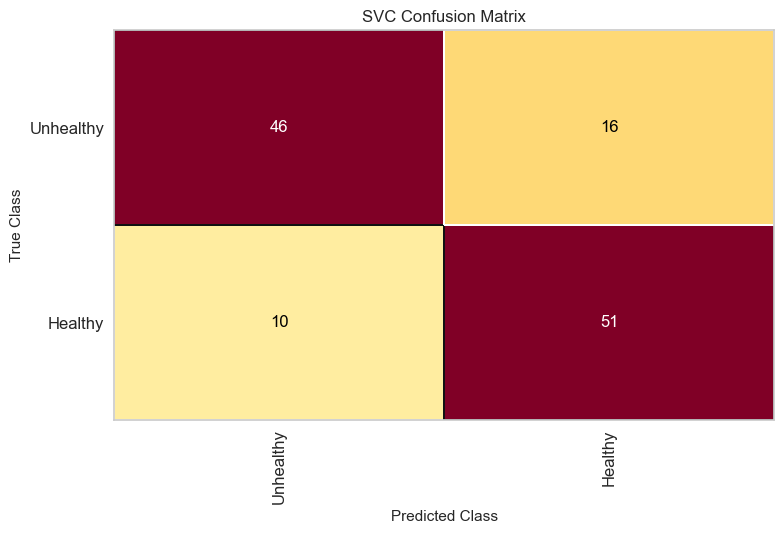

<Axes: title={'center': 'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [8]:
from yellowbrick.classifier import ConfusionMatrix

# Visualize confusion matrix
viz = ConfusionMatrix(svm, classes=["Unhealthy", "Healthy"])
viz.score(X_test_pca, y_test)
viz.show()



In [ ]:
import matplotlib.pyplot as plt

# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
scatter = ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set(
    title="First three PCA dimensions",
    xlabel="1st Eigenvector",
    ylabel="2nd Eigenvector",
    zlabel="3rd Eigenvector",
)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# Add a legend
legend1 = ax.legend(
    scatter.legend_elements()[0],
    iris.target_names.tolist(),
    loc="upper right",
    title="Classes",
)
ax.add_artist(legend1)

plt.show()

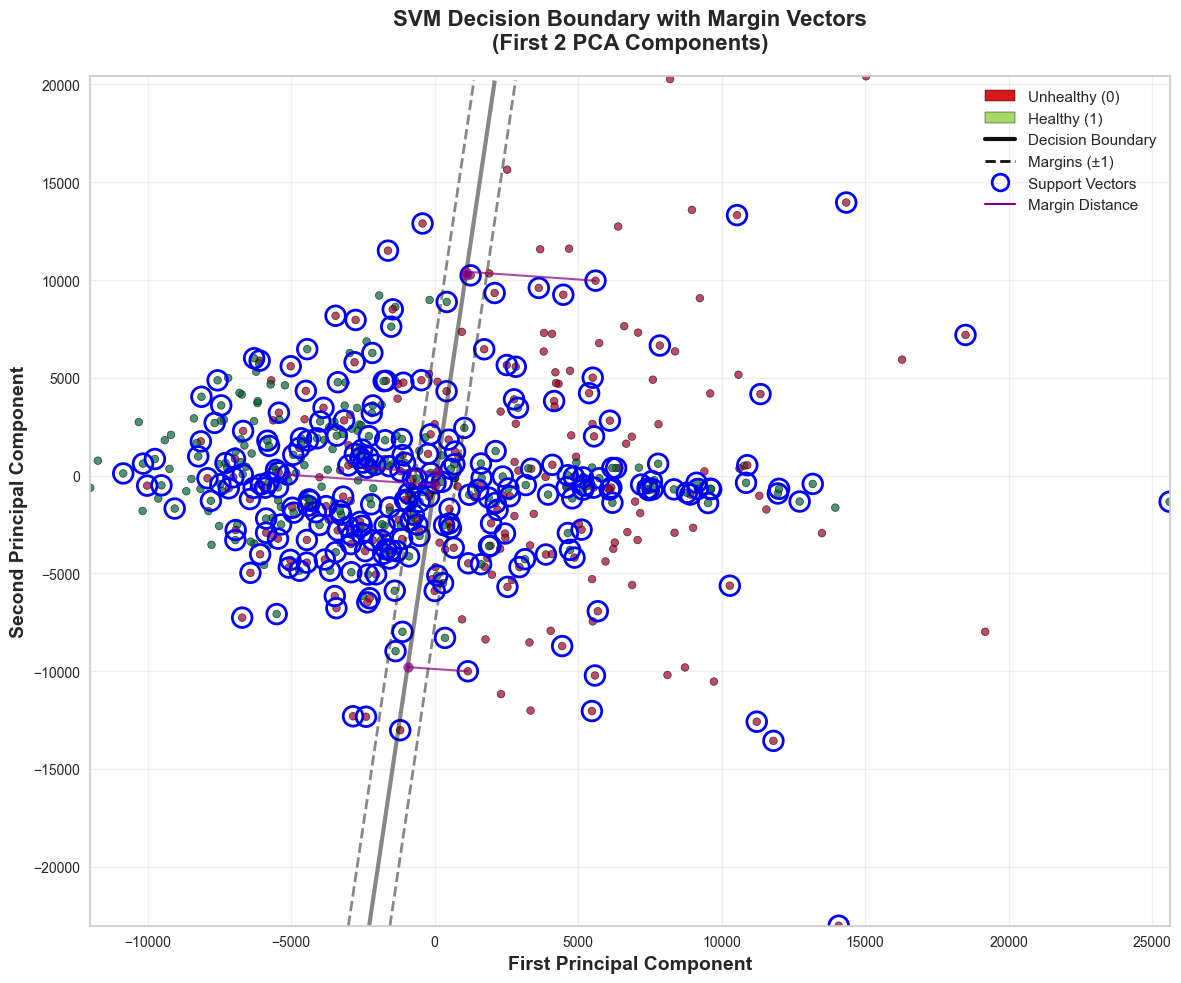

2D LINEAR SVM WITH MARGIN ANALYSIS
Number of support vectors: 265
Support vectors per class: [133 132]
Margin width: 1441.1491
Hyperplane equation: -0.0014*PC1 + 0.0001*PC2 + 0.0704 = 0

Training accuracy (2D): 0.6660 (66.60%)
Variance explained by first 2 components: 20.88%


In [9]:
# ============================================================================
# 2D DECISION BOUNDARY WITH DETAILED MARGINS (First 2 PCA Components)
# ============================================================================

# Train a linear SVM on first 2 PCA components for visualization
clf = SVC(kernel='linear', random_state=42)
clf.fit(X_train_pca[:, :2], y_train)

# Get data for mesh grid
X_2d = X_train_pca[:, :2]
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1

# Create mesh for decision boundary contours
h = max(x_max - x_min, y_max - y_min) / 200  # adaptive step size
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary and margins
plt.figure(figsize=(12, 10))

# Scatter plot of data points
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_train, s=30, cmap=plt.cm.RdYlGn, 
           edgecolors='black', linewidths=0.5, alpha=0.7)

# Plot decision boundary and margins using contour
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], linewidths=[2, 3, 2])

# Highlight support vectors
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=200,
           linewidth=2, facecolors='none', edgecolors='blue')

# Plot margin vectors for first 5 support vectors (to avoid clutter)
theta = clf.coef_[0]
theta0 = clf.intercept_[0]
num_margin_vectors = min(5, len(clf.support_))  # Show max 5 margin vectors

for idx in clf.support_[:num_margin_vectors]:
    x0 = X_2d[idx]
    
    # Calculate margin distance for this support vector
    margin_x0 = (theta.dot(x0) + theta0) / np.linalg.norm(theta)
    w = theta / np.linalg.norm(theta)
    
    # Draw line from support vector to decision boundary (perpendicular)
    plt.plot([x0[0], x0[0] - w[0] * margin_x0], 
            [x0[1], x0[1] - w[1] * margin_x0], 
            color='purple', linewidth=1.5, alpha=0.7)
    
    # Mark the projection point on decision boundary
    plt.scatter([x0[0] - w[0] * margin_x0], 
               [x0[1] - w[1] * margin_x0], 
               color='purple', s=50, alpha=0.7, zorder=5)

# Set axis limits
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])

# Labels and title
plt.xlabel('First Principal Component', fontsize=14, fontweight='bold')
plt.ylabel('Second Principal Component', fontsize=14, fontweight='bold')
plt.title('SVM Decision Boundary with Margin Vectors\n(First 2 PCA Components)', 
         fontsize=16, fontweight='bold', pad=20)

# Create custom legend
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Patch(facecolor='#d7191c', edgecolor='black', label='Unhealthy (0)'),
    Patch(facecolor='#a6d96a', edgecolor='black', label='Healthy (1)'),
    Line2D([0], [0], color='k', linewidth=3, label='Decision Boundary'),
    Line2D([0], [0], color='k', linewidth=2, linestyle='--', label='Margins (±1)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markeredgecolor='blue', markersize=12, markeredgewidth=2, 
           label='Support Vectors'),
    Line2D([0], [0], color='purple', linewidth=1.5, label='Margin Distance')
]
plt.legend(handles=legend_elements, loc='best', fontsize=11)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print analysis
print("="*70)
print("2D LINEAR SVM WITH MARGIN ANALYSIS")
print("="*70)
print(f"Number of support vectors: {len(clf.support_vectors_)}")
print(f"Support vectors per class: {clf.n_support_}")
print(f"Margin width: {2 / np.linalg.norm(theta):.4f}")
print(f"Hyperplane equation: {theta[0]:.4f}*PC1 + {theta[1]:.4f}*PC2 + {theta0:.4f} = 0")

# Calculate accuracy
y_pred_2d = clf.predict(X_2d)
accuracy_2d = np.mean(y_pred_2d == y_train)
print(f"\nTraining accuracy (2D): {accuracy_2d:.4f} ({accuracy_2d*100:.2f}%)")
print(f"Variance explained by first 2 components: {np.sum(pca.explained_variance_ratio_[:2])*100:.2f}%")
print("="*70)



Dataset prepared:
Training batches: 31
Test batches: 8

Model Architecture:
SimpleNeuralNetwork(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 6594

Starting Training...
Epoch [1/35] | Loss: 104.0158 | Train Acc: 55.80% | Test Acc: 57.72%
Epoch [5/35] | Loss: 5.7609 | Train Acc: 88.39% | Test Acc: 69.11%
Epoch [10/35] | Loss: 2.5007 | Train Acc: 93.89% | Test Acc: 65.04%
Epoch [15/35] | Loss: 0.3677 | Train Acc: 98.17% | Test Acc: 68.29%
Epoch [20/35] | Loss: 0.1993 | Train Acc: 98.98% | Test Acc: 65.85%
Epoch [25/35] | Loss: 0.9775 | Train Acc: 97.35% | Test Acc: 62.60%
Epoch [30/35] | Loss: 0.9087 | Train Acc: 97.15% | Test Acc: 61.79%
Epoch [35/35] | Loss: 0.5537 | Train Acc: 98.57% | Test Acc: 65.04%

Training Complete!

NEURAL NETWORK - Classification Report:
              precision    recall  f1-score   support

   Unhealthy       0.64      0.71      0.67        62
   

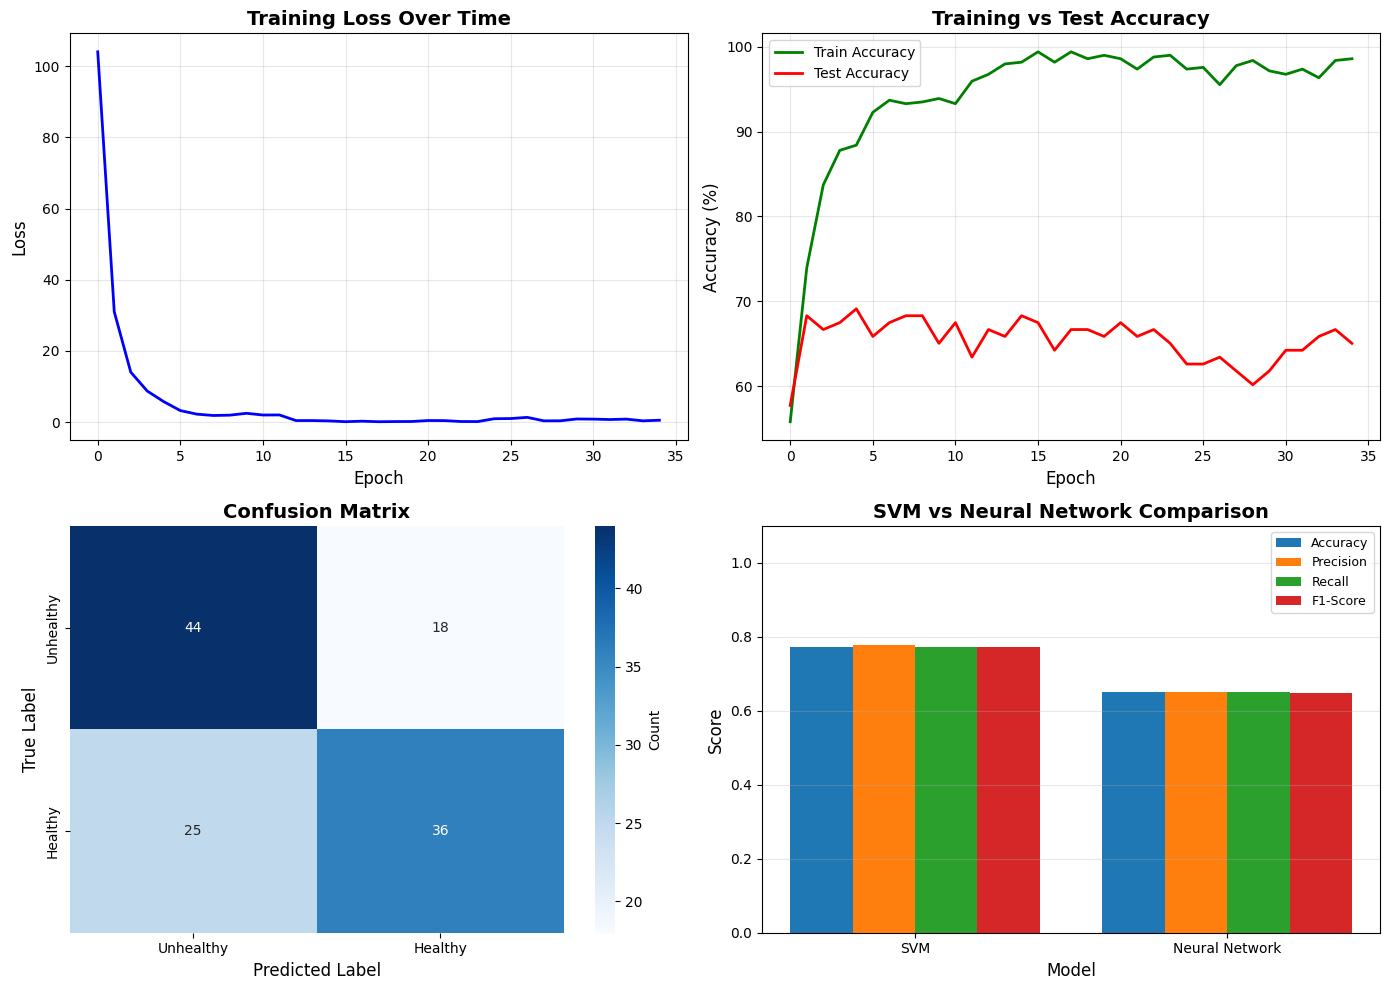


Visualization saved as 'neural_network_results.png'
Model saved as 'vegetation_nn_model.pth'


In [22]:
torch.manual_seed(42)
np.random.seed(42)

class SimpleNeuralNetwork(nn.Module):
    """
    Simple Neural Network with:
    - Input layer (based on PCA components)
    - One hidden layer with ReLU activation
    - Output layer with 2 classes (Healthy/Unhealthy)
    """
    def __init__(self, input_size, hidden_size=64, num_classes=2):
        super(SimpleNeuralNetwork, self).__init__()
        
        # Input to hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()  # Activation function
        
        # Hidden to output layer
        self.fc2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        """Forward pass through the network"""
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

device = ('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data for PyTorch
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_pca).to(device)
X_test_tensor = torch.FloatTensor(X_test_pca).to(device)
y_train_tensor = torch.LongTensor(y_train).to(device)
y_test_tensor = torch.LongTensor(y_test).to(device)

# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataset prepared:")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")


# Initialize the model
input_size = X_train_pca.shape[1]  # Number of PCA components
hidden_size = 64
num_classes = 2

model = SimpleNeuralNetwork(input_size, hidden_size, num_classes).to(device)

# Display model architecture
print(f"\nModel Architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
num_epochs = 35

# Lists to store training history
train_losses = []
train_accuracies = []
test_accuracies = []

print("\n" + "="*50)
print("Starting Training...")
print("="*50)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Evaluate on test set
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct_test / total_test
    
    # Store history
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    
    # Print progress every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Loss: {epoch_loss:.4f} | "
              f"Train Acc: {train_accuracy:.2f}% | "
              f"Test Acc: {test_accuracy:.2f}%")

print("\n" + "="*50)
print("Training Complete!")
print("="*50)


# Final Evaluation on Test Set
model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_pred_nn = np.array(all_predictions)
y_test_nn = np.array(all_labels)

# Classification Report
print("\n" + "="*50)
print("NEURAL NETWORK - Classification Report:")
print("="*50)
print(classification_report(y_test_nn, y_pred_nn, 
                          target_names=["Unhealthy", "Healthy"]))


# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Training Loss
axes[0, 0].plot(train_losses, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Training and Test Accuracy
axes[0, 1].plot(train_accuracies, 'g-', label='Train Accuracy', linewidth=2)
axes[0, 1].plot(test_accuracies, 'r-', label='Test Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training vs Test Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# 3. Confusion Matrix
cm = confusion_matrix(y_test_nn, y_pred_nn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Unhealthy", "Healthy"],
            yticklabels=["Unhealthy", "Healthy"],
            ax=axes[1, 0], cbar_kws={'label': 'Count'})
axes[1, 0].set_xlabel('Predicted Label', fontsize=12)
axes[1, 0].set_ylabel('True Label', fontsize=12)
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# 4. Model Comparison (if SVM results are available)
try:
    # Get SVM predictions (from your previous code)
    y_pred_svm = svm.predict(X_test_pca)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    models = ['SVM', 'Neural Network']
    metrics = {
        'Accuracy': [accuracy_score(y_test, y_pred_svm), 
                    accuracy_score(y_test_nn, y_pred_nn)],
        'Precision': [precision_score(y_test, y_pred_svm, average='weighted'),
                     precision_score(y_test_nn, y_pred_nn, average='weighted')],
        'Recall': [recall_score(y_test, y_pred_svm, average='weighted'),
                  recall_score(y_test_nn, y_pred_nn, average='weighted')],
        'F1-Score': [f1_score(y_test, y_pred_svm, average='weighted'),
                    f1_score(y_test_nn, y_pred_nn, average='weighted')]
    }
    
    x = np.arange(len(models))
    width = 0.2
    
    for i, (metric, values) in enumerate(metrics.items()):
        axes[1, 1].bar(x + i*width, values, width, label=metric)
    
    axes[1, 1].set_xlabel('Model', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('SVM vs Neural Network Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xticks(x + width * 1.5)
    axes[1, 1].set_xticklabels(models)
    axes[1, 1].legend(fontsize=9)
    axes[1, 1].set_ylim([0, 1.1])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
except:
    axes[1, 1].text(0.5, 0.5, 'SVM results not available\nfor comparison', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].set_xlim([0, 1])
    axes[1, 1].set_ylim([0, 1])
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('neural_network_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'neural_network_results.png'")


# Save the trained model (optional)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
}, 'vegetation_nn_model.pth')

print("Model saved as 'vegetation_nn_model.pth'")